In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Dense, LSTM, Dropout, TimeDistributed, Lambda

# LSTM 기반의 가우시안 분포를 추정하는 Simple DeepAR
# 원리만 알면 뭐든 만들 수 있다.

# 챌린지
# 1. Seq2Seq로 변환.
# 2. LSTM이 아닌 다른 모델의 도입 (CNN-LSTM, GRU)
# 3. 분포 함수를 바꿔보기 => 분포 추정 계수를 mu, sigma가 아니고 다른 값으로 변경이 필요.
# 2주 정도 시간 들여서 해보기. (6주차에 솔루션 업로드)
# 4. 분포 함수 자체를 딥러닝으로 모델링 하기.  (5,6주차 때 다룰 예정, GAN/AutoEncoder)

class DeepAR(tf.keras.models.Model):
    def __init__(self, lstm_units, n_steps_in, n_steps_out, n_features):
        super().__init__()

        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, input_shape=(n_steps_in, n_features))
        self.dense_mu = tf.keras.layers.Dense(1) # 정규분포 (가우시안 분포)의 평균
        self.dense_sigma = tf.keras.layers.Dense(1, activation='softplus') # 정규분포 (가우시안 분포)의 시그마

    def call(self, inputs, initial_state=None):
        outputs, state_h, state_c = self.lstm(inputs, initial_state=initial_state)

        mu = self.dense_mu(outputs) # 정규분포의 평균을 추정하는 레이어
        sigma = self.dense_sigma(outputs) # 정규분포의 표준편차를 추정하는 레이어
        state = [state_h, state_c]

        return [mu, sigma, state]

# 모델의 로스를 계산하는 부분,
def log_gaussian_loss(mu, sigma, y_true):
    """
    Gaussian loss function
    """
                              # 모델링된 mu와 sigma를 가지고 분포 생성
                                                                    # y_true=실제값과 분포에서 샘플링된 값의 차이를 구함.
    return -tf.reduce_sum(tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(y_true))


In [2]:
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv('/content/drive/MyDrive/시계열_교안/3주차/Gemini_ETHUSD_d.csv',  skiprows=1, parse_dates=True, index_col='Date')
df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)

test_cutoff_date = df.index.max() - timedelta(days=90)

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']


############# 데이터를 정규화
training_mean = df_train.mean() # train의 평균
training_std = df_train.std() # train의 편차
df_training_value = (df_train - training_mean) / training_std # 데이터 = (원본 - 평균) / 편차로 정규화

test_mean = df_test.mean() # test의 평균
test_std = df_test.std() # test의 편차
df_test_value = (df_test - test_mean) / test_std # 데이터 = (원본 - 평균) / 편차로 정규화


##############

from numpy import array

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

raw_seq = df_training_value
n_steps_in = 30
n_steps_out = 1

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

test_raw_seq = df_test_value

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [3]:
LSTM_UNITS = 128
EPOCHS = 100

model = DeepAR(LSTM_UNITS, n_steps_in, n_steps_out, n_features)

# optmizer
optimizer = tf.keras.optimizers.Adam()


# metric
rmse = tf.keras.metrics.RootMeanSquaredError()

def train_step(x, y):
    with tf.GradientTape() as tape:
        mu, sigma, _ = model(x)
        loss = log_gaussian_loss(mu, sigma, y) # Forward Learning
    # backword
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    rmse(y, mu)

for epoch in range(EPOCHS):
    train_step(X, y)
    print('Epoch %d, RMSE %.4f' % (epoch + 1, rmse.result().numpy()))
    rmse.reset_states()

Epoch 1, RMSE 1.0153
Epoch 2, RMSE 0.9684
Epoch 3, RMSE 0.9190
Epoch 4, RMSE 0.8669
Epoch 5, RMSE 0.8125
Epoch 6, RMSE 0.7567
Epoch 7, RMSE 0.7010
Epoch 8, RMSE 0.6482
Epoch 9, RMSE 0.6023
Epoch 10, RMSE 0.5682
Epoch 11, RMSE 0.5504
Epoch 12, RMSE 0.5492
Epoch 13, RMSE 0.5568
Epoch 14, RMSE 0.5610
Epoch 15, RMSE 0.5561
Epoch 16, RMSE 0.5446
Epoch 17, RMSE 0.5311
Epoch 18, RMSE 0.5193
Epoch 19, RMSE 0.5111
Epoch 20, RMSE 0.5062
Epoch 21, RMSE 0.5036
Epoch 22, RMSE 0.5017
Epoch 23, RMSE 0.4999
Epoch 24, RMSE 0.4985
Epoch 25, RMSE 0.4999
Epoch 26, RMSE 0.5040
Epoch 27, RMSE 0.5007
Epoch 28, RMSE 0.4994
Epoch 29, RMSE 0.5005
Epoch 30, RMSE 0.5017
Epoch 31, RMSE 0.5024
Epoch 32, RMSE 0.5026
Epoch 33, RMSE 0.5012
Epoch 34, RMSE 0.5021
Epoch 35, RMSE 0.5001
Epoch 36, RMSE 0.5014
Epoch 37, RMSE 0.4986
Epoch 38, RMSE 0.4934
Epoch 39, RMSE 0.4901
Epoch 40, RMSE 0.4883
Epoch 41, RMSE 0.4844
Epoch 42, RMSE 0.4818
Epoch 43, RMSE 0.4795
Epoch 44, RMSE 0.4759
Epoch 45, RMSE 0.4715
Epoch 46, RMSE 0.46

In [4]:
# 샘플링된 값들을 예측값으로 반환.
pred = model.predict(test_X)

In [5]:
pred[0].shape

# median => 실제 예측값.
# 5% 퍼센타일 => lower bound
# 95% 퍼센타일 => upper bound

(60, 30, 1)

In [6]:
test_y.shape # 라벨의 shape

(60, 1)

In [7]:
pred

[array([[[ 0.00375745],
         [ 0.05538939],
         [ 0.06688571],
         ...,
         [-0.317282  ],
         [-0.27606174],
         [-0.37531182]],
 
        [[ 0.0531773 ],
         [ 0.06393442],
         [ 0.04925732],
         ...,
         [-0.2691417 ],
         [-0.3688169 ],
         [-0.51848423]],
 
        [[-0.01661271],
         [-0.04145579],
         [-0.07980591],
         ...,
         [-0.3619364 ],
         [-0.51268977],
         [-0.7508252 ]],
 
        ...,
 
        [[-0.02654277],
         [-0.10385727],
         [-0.14198042],
         ...,
         [ 1.8387892 ],
         [ 1.7937437 ],
         [ 1.8140596 ]],
 
        [[-0.05568932],
         [-0.08904643],
         [-0.02701679],
         ...,
         [ 1.7906315 ],
         [ 1.8104753 ],
         [ 1.8479257 ]],
 
        [[ 0.00648094],
         [ 0.07878234],
         [ 0.17945875],
         ...,
         [ 1.8068731 ],
         [ 1.8441938 ],
         [ 1.866378  ]]], dtype=float32), arra

In [8]:
test_y

array([[-1.16902354],
       [-1.76620325],
       [-0.98994393],
       [-0.97656869],
       [-0.92306773],
       [-0.84355935],
       [-0.92405848],
       [-0.78807687],
       [-0.78708611],
       [-0.94164445],
       [-1.13013626],
       [-1.11998099],
       [-0.96245038],
       [-0.93619528],
       [-1.25571491],
       [-1.22277219],
       [-0.9882101 ],
       [-0.64218768],
       [-0.50001382],
       [-0.42001007],
       [-0.11312261],
       [-0.25752567],
       [-0.29616525],
       [-0.33232794],
       [-0.63872002],
       [-0.56193623],
       [-0.32762184],
       [-0.29121146],
       [-0.55723013],
       [ 0.00527304],
       [ 0.579913  ],
       [ 0.45631587],
       [ 0.52789817],
       [ 0.37086294],
       [ 0.05580172],
       [ 0.31191281],
       [-0.06135548],
       [-0.09578434],
       [-0.20996926],
       [-0.10841651],
       [ 0.13605317],
       [-0.17876036],
       [-0.07373996],
       [ 0.28144698],
       [ 0.6371293 ],
       [ 1

In [9]:
import numpy as np
lower_bound = []
upper_bound = []
median = []
for step_pred in pred[0]:
                           # 정규화된 값을 원래대로.
  lb = (np.quantile(step_pred, 0.05) + test_mean) * test_std
  ub = (np.quantile(step_pred, 0.95) + test_mean) * test_std
  med = (np.quantile(step_pred, 0.5) + test_mean) * test_std
  lower_bound.append(lb)
  upper_bound.append(ub)
  median.append(med)

In [10]:
lower_bound

[15759.418651077514,
 15759.49281503946,
 15759.595241736874,
 15759.663648929474,
 15758.683656318428,
 15757.68990978735,
 15757.674821023573,
 15757.710260439246,
 15757.822162072716,
 15757.921244200845,
 15758.00771353551,
 15758.085734153901,
 15758.178878669874,
 15758.275882850327,
 15758.359853113,
 15758.451431768459,
 15758.329525665189,
 15757.734879125885,
 15757.806167771347,
 15757.89817862067,
 15757.981473399948,
 15758.136527280707,
 15757.921554388982,
 15757.76309950828,
 15757.569910294325,
 15757.31964381626,
 15757.436690866894,
 15757.479047068911,
 15757.59163814304,
 15758.468934657434,
 15759.795785225171,
 15759.70281060278,
 15759.245083609432,
 15758.981955994877,
 15758.648948455844,
 15758.313043581546,
 15758.067811343826,
 15757.954425908922,
 15758.177238932125,
 15758.815714645967,
 15760.337573684688,
 15762.25098592687,
 15765.335083689451,
 15768.165206553278,
 15772.026452295046,
 15778.067720230647,
 15784.023270839283,
 15786.05020249406,
 1578

In [ ]:
upper_bound

[15839.761932124917,
 15839.531084651448,
 15839.532902103656,
 15839.151441926424,
 15838.82543960984,
 15838.873556672124,
 15837.934147931346,
 15836.668115414821,
 15831.87508123686,
 15824.903135189397,
 15809.040928965302,
 15796.29878318146,
 15793.181356212011,
 15792.42809422332,
 15792.77919055557,
 15792.280174248568,
 15791.643741348602,
 15790.528841744685,
 15793.46979574398,
 15795.399244339802,
 15794.961670776807,
 15791.856018623605,
 15792.325173186124,
 15791.545469283168,
 15795.56103992447,
 15799.405438426455,
 15797.410949493069,
 15793.087293404398,
 15788.687136083769,
 15788.550125213997,
 15789.035098168244,
 15789.306732734545,
 15795.711929382107,
 15800.825018112391,
 15807.830753053986,
 15813.462609949518,
 15815.765609346225,
 15815.885892316075,
 15816.017960690438,
 15816.174979176272,
 15816.381696828268,
 15816.652528731629,
 15816.955918056356,
 15817.251608205923,
 15817.544767037416,
 15817.860802304107,
 15818.764241554023,
 15819.430220956843,

In [ ]:
test_cutoff_date

Timestamp('2020-08-22 00:00:00')

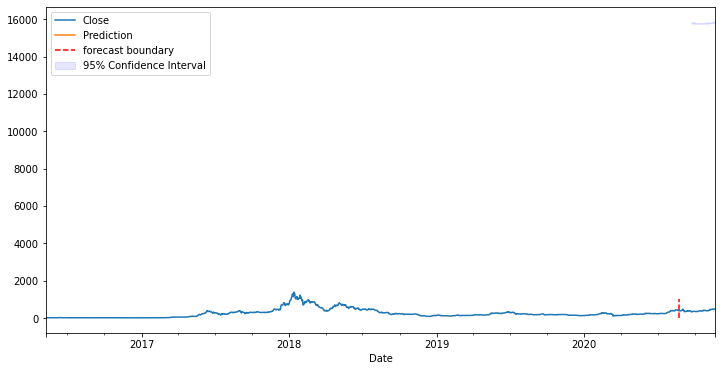

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)


df['Close'].plot(ax=ax)
ax.vlines('2020-08-22', 0, 1000, linestyle='--', color='r', label='forecast boundary')
ax.fill_between(df_test[30:].index, lower_bound, upper_bound, color='b', alpha=0.1, label='95% Confidence Interval')
ax.plot(df_test[30:].index, median, label='Prediction')
ax.legend(loc='upper left')
# plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2}")
# plt.show()

In [ ]:
!nvidia-smi

Sat Aug  7 03:51:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------